In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
savedModelName = 'carsModelV2.pth'

In [9]:
def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = transforms.ToTensor()(img)
    return tensor

# Pobranie danych
trainigSet = torchvision.datasets.ImageFolder(
    root='data/ModelsAugV2/Train',
    transform=transform
)

tesingSet = torchvision.datasets.ImageFolder(
    root='data/ModelsAugV2/Test',
    transform=transform
)

batch=100
# Ładowanie danych
trainLoader = DataLoader(trainigSet, batch_size=batch, shuffle=True)
testLoader = DataLoader(tesingSet, batch_size=batch, shuffle=True)

In [10]:
print(trainigSet.class_to_idx)
classes = ('Cab', 'Convertible', 'Coupe', 'Hatchback', 'Minivan', 'SUV', 'Sedan', 'Van')
print(classes)

{'Cab': 0, 'ConvertibleCoupe': 1, 'SUV': 2, 'Sedan': 3, 'VanMinivan': 4}
('Cab', 'Convertible', 'Coupe', 'Hatchback', 'Minivan', 'SUV', 'Sedan', 'Van')


In [11]:
from torch import nn
import numpy as np

class TransferFeatures(nn.Module):
    def __init__(self, pretrainedModel, classifier):
        super(TransferFeatures, self).__init__()

        print(pretrainedModel)
        self.features = pretrainedModel.features
        self.classifier = classifier

        # Freeze those weights
        #for p in self.features.parameters():
        #    p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

m1 = torchvision.models.alexnet(pretrained=True)

classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 8),
)

model = TransferFeatures(m1, classifier)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Starting epoch  1
Epoch loss: 1.166289873601158
Starting epoch  2
Epoch loss: 0.7134710417133598
Starting epoch  3
Epoch loss: 0.5211624074817279
Starting epoch  4
Epoch loss: 0.40858770349031487
Starting epoch  5
Epoch loss: 0.32873096793961987
Starting epoch  6
Epoch loss: 0.26563951085155135
Starting epoch  7
Epoch loss: 0.22169832982446835
Starting epoch  8
Epoch loss: 0.1859726827290215
Starting epoch  9
Epoch loss: 0.15790868866378846
Starting epoch  10
Epoch loss: 0.14006284001656777
Starting epoch  11
Epoch loss: 0.12203912344729699
Starting epoch  12
Epoch loss: 0.10692916762821628
Starting epoch  13
Epoch loss: 0.09441972985539747
Starting epoch  14
Epoch loss: 0.07907484386314229
Starting epoch  15
Epoch loss: 0.07225212810453081
Starting epoch  16
Epoch loss: 0.06735688367192656
Starting epoch  17
Epoch loss: 0.06102479401309997
Starting epoch  18
Epoch loss: 0.055286952740949205
Starting epoch  19
Epoch loss: 0.050271475561647024
Starting epoch  20
Epoch loss: 0.0497960096

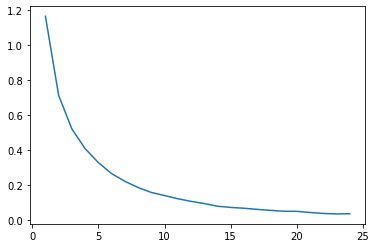

In [12]:
# Trenowanie sieci
noEpochs = 40
epochsRun = 0
prev_epoch = 1
loss_vals=  []
for epoch in range(noEpochs):

    epoch_loss= []
    print("Starting epoch ", epoch + 1)

    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    print('Epoch loss:', loss_vals[epoch])
    epochsRun = epoch + 1
    if epoch > 0 and loss_vals[epoch-1] < loss_vals[epoch]:
        break

torch.save(model, savedModelName)
print('Finished Training')

plt.plot(np.linspace(1, epochsRun, epochsRun).astype(int), loss_vals)

[[ 3  0  0  1  0]
 [ 0  6  1  2  0]
 [ 0  0 12  0  0]
 [ 1  2  1 20  0]
 [ 0  0  0  0  7]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      0.67      0.71         9
           2       0.86      1.00      0.92        12
           3       0.87      0.83      0.85        24
           4       1.00      1.00      1.00         7

    accuracy                           0.86        56
   macro avg       0.85      0.85      0.85        56
weighted avg       0.86      0.86      0.85        56



<AxesSubplot:>

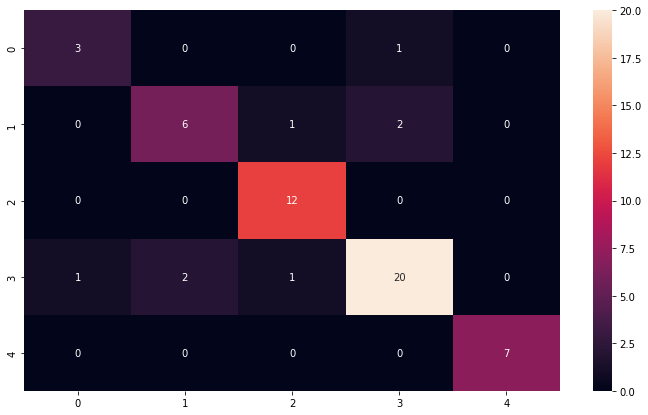

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

model = torch.load(savedModelName)

model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')

for i, data in enumerate(testLoader, 0):
    inputs, labels = data
    
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


print(confusion_matrix(y_trues,
                       y_preds))


print(classification_report(y_trues,
                            y_preds))

plt.figure(figsize = (12,7))
sn.heatmap(confusion_matrix(y_trues, y_preds), annot=True)

[[ 96   0   0   0   0]
 [  0  69   0   0   0]
 [  0   0 107   0   0]
 [  0   0   0  66   0]
 [  0   0   0   0  76]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00       107
           3       1.00      1.00      1.00        66
           4       1.00      1.00      1.00        76

    accuracy                           1.00       414
   macro avg       1.00      1.00      1.00       414
weighted avg       1.00      1.00      1.00       414



<AxesSubplot:>

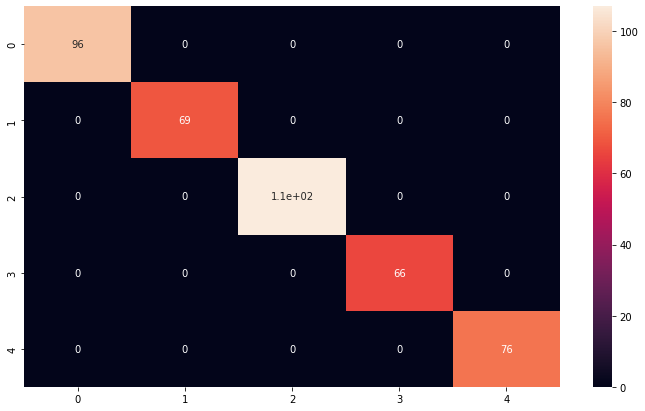

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

model = torch.load(savedModelName)

model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')

for i, data in enumerate(trainLoader, 0):
    inputs, labels = data
    
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


print(confusion_matrix(y_trues,
                       y_preds))


print(classification_report(y_trues,
                            y_preds))

plt.figure(figsize = (12,7))
sn.heatmap(confusion_matrix(y_trues, y_preds), annot=True)

In [15]:
classesDict = str(trainigSet.class_to_idx).split(',')
for i in classesDict:
    print(i)

{'Cab': 0
 'ConvertibleCoupe': 1
 'SUV': 2
 'Sedan': 3
 'VanMinivan': 4}


C:\Users\creep\AppData\Local\Temp\ipykernel_69368\2633801592.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


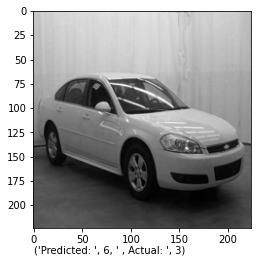

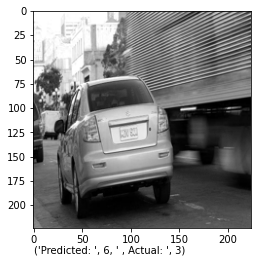

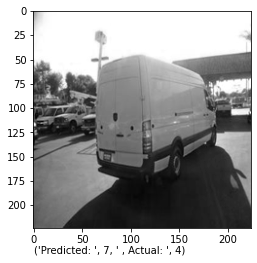

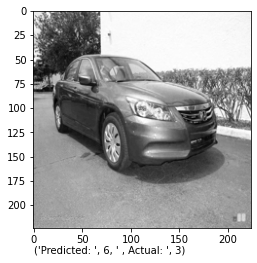

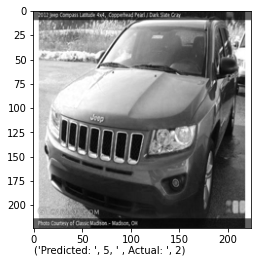

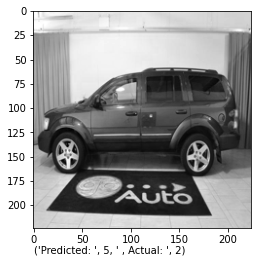

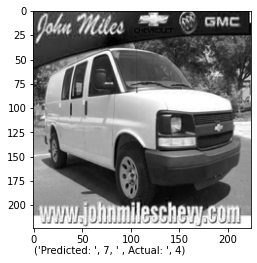

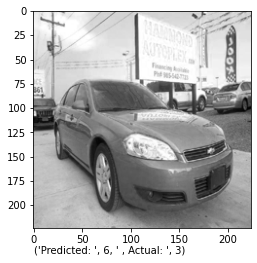

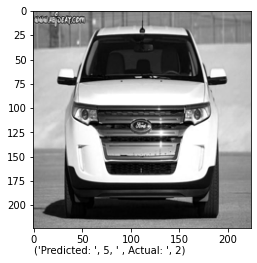

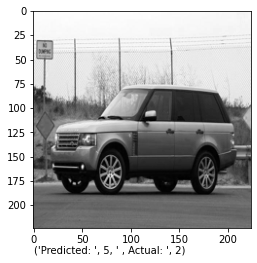

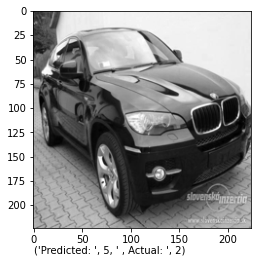

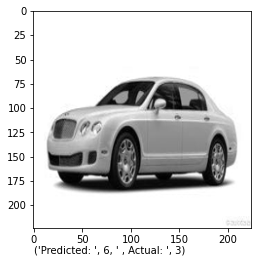

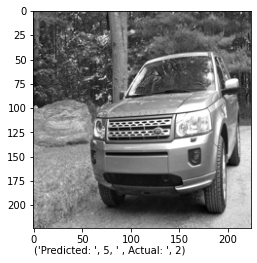

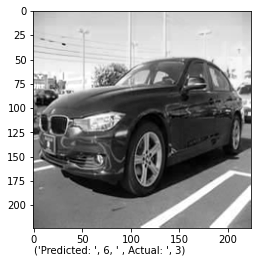

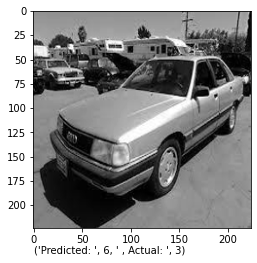

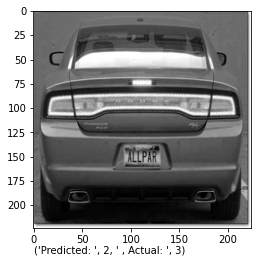

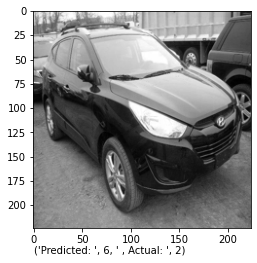

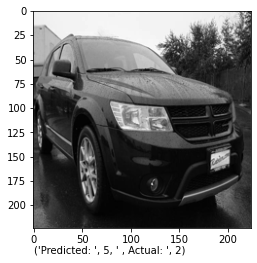

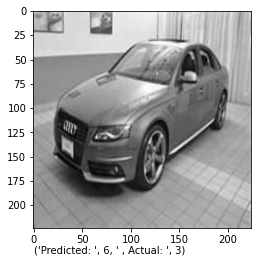

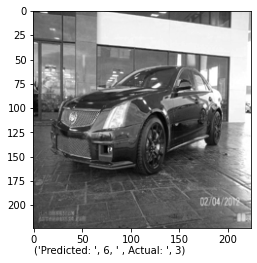

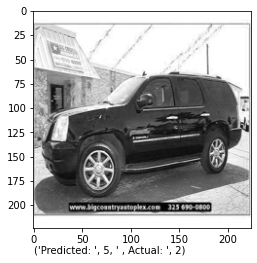

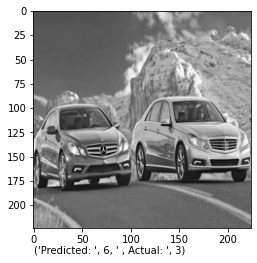

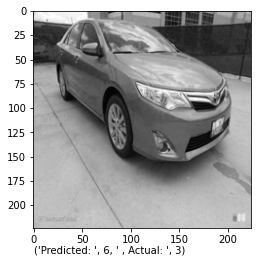

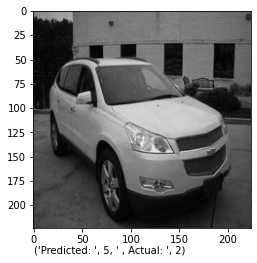

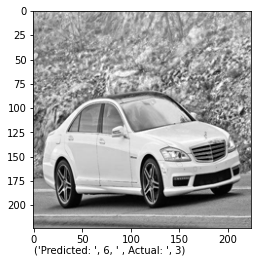

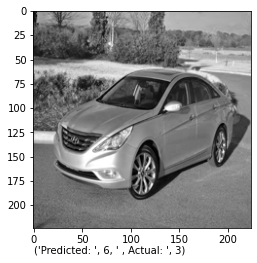

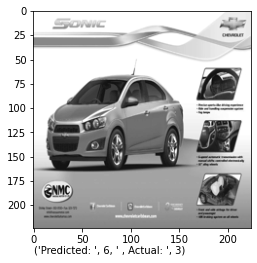

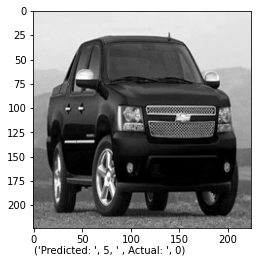

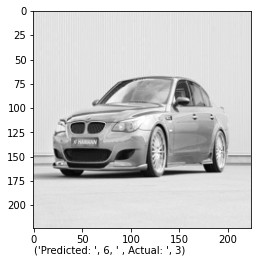

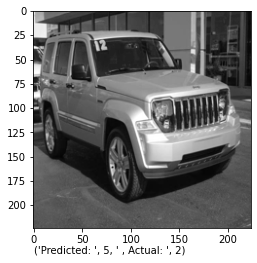

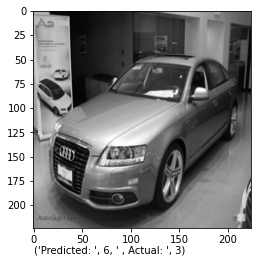

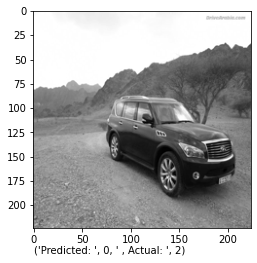

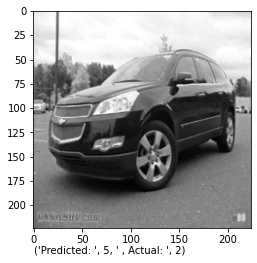

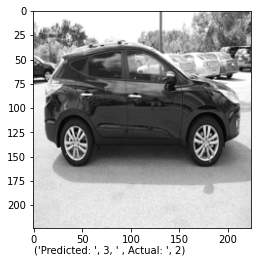

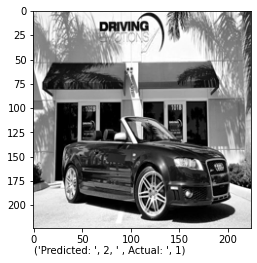

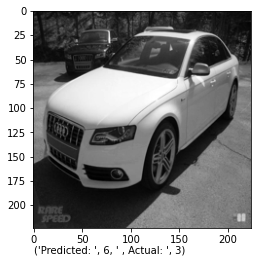

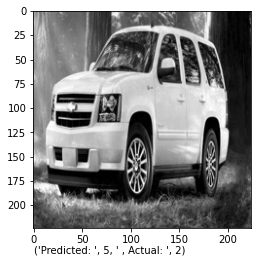

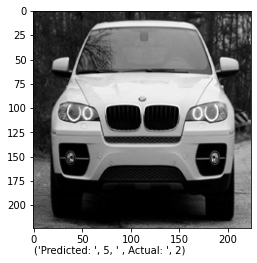

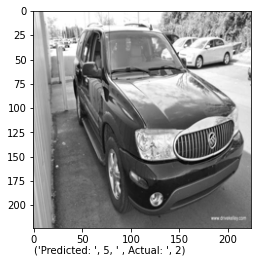

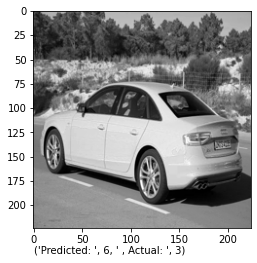

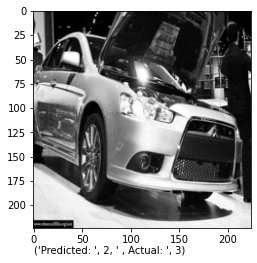

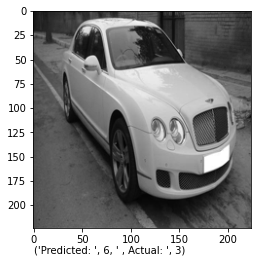

In [16]:
model = torch.load('carsModel.pth')

j = 0

pred = []
act = []
# Przykłady złej klasyfikacji
for i, (samples, labels) in enumerate(testLoader):

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

    if output[j] != labels[j]:
        text = 'Predicted: ', output[j], ' , Actual: ', labels[j]

        img = samples[j][0]

        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.text(0, 250, text)

    j+=1
    if (j >= 4):
        j = 0